In [2]:
### Author: Julian Viereck
### Date: 13 Jan 2020
### Put together full step adjustment algorithm for stepping in place.

import numpy as np
np.set_printoptions(precision=2, suppress=True)

import time

import os
import rospkg
import pybullet as p
import pinocchio as se3
from pinocchio.utils import se3ToXYZQUAT

from robot_properties_solo.config import Solo12Config
from robot_properties_solo.quadruped12wrapper import Quadruped12Robot

from py_blmc_controllers.solo_centroidal_controller import SoloCentroidalController
from py_blmc_controllers.solo_impedance_controller import SoloImpedanceController 

from pinocchio.utils import zero
from matplotlib import pyplot as plt

from py_dcm_vrp_planner.planner import DcmVrpPlanner


#######################################################################################

# Create a robot instance. This initializes the simulator as well.
robot = Quadruped12Robot()
tau = np.zeros(12)

p.resetDebugVisualizerCamera(1.2, 135, -30, (0,0,0.1))

Solo12Config.initial_configuration[0] = 0.0
Solo12Config.initial_configuration[2] = 0.25

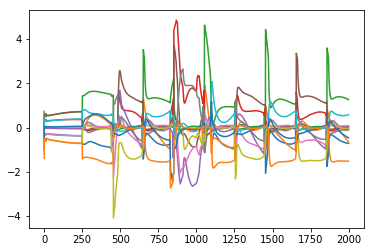

In [77]:
# Reset the robot to some initial state.
q0 = np.matrix(Solo12Config.initial_configuration).T
dq0 = np.matrix(Solo12Config.initial_velocity).T
robot.reset_state(q0, dq0)

arr = lambda a: np.array(a).reshape(-1)
mat = lambda a: np.matrix(a).reshape((-1, 1))
total_mass = sum([i.mass for i in robot.pin_robot.model.inertias[1:]])

def zero_cnt_gain(kp, cnt_array):
    gain = np.array(kp).copy()
    for i, v in enumerate(cnt_array):
        if v == 1:
            gain[3*i:3*(i + 1)] = 0.

    return gain

#######################################################

warmup = 250
x_des = np.array(4*[0.0, 0.0, 0.])
xd_des = 4*[0,0,0] 
kp = np.array(12 * [50.])
kp[2::3] = 100
kd = 12 * [5.]
##################################################################################

ht = 0.20
x_com_cent = [0.0, 0.0, ht]
xd_com_cent = [0.0, 0.0, 0.0]

x_ori = [0., 0., 0., 1.]
x_angvel = [0., 0., 0.]
cnt_array = [1, 1, 1, 1]

solo_leg_ctrl = SoloImpedanceController(robot)
centr_controller = SoloCentroidalController(robot.pin_robot, total_mass,
        mu=0.6, kc=100, dc=10, kb=[5000, 5000, 500], db=5.,
        eff_ids=robot.pinocchio_endeff_ids)

# Positions of the foot at zero positions of solo12.
x0 = np.array([
    0.195, 0.147, 0,
    0.195, -0.147, 0,
    -0.195, 0.147, 0,
    -0.195, -0.147, 0,
])

x_des = x0.copy()

#################################################################################

l_min = -0.15
l_max = 0.15
w_min = -0.15
w_max = 0.15
t_min = 0.1
t_max = 0.3
v_des = [0.5, 0.0]
l_p = 0

dcm_vrp_planner = DcmVrpPlanner(l_min, l_max, w_min, w_max, t_min, t_max, v_des, l_p, ht)

W = [100, 100, 1.0, 1000, 1000, 100] # weight on [step length_x , step_length_y, step time, dcm_offeset_x, dcm_offeset_y]
#######################################################################################

solo_leg_ctrl = SoloImpedanceController(robot)

# Run the simulator for 100 steps
t = 0
t_gap = 0.05
t_end = t_max
n = 1
u_current_step = [0.0, 0.0]
u_old = [0.0, 0.0]
x_com = np.array([0.0, 0.0]) 
xd_com = np.array([0.0, 0.0]) 

## for plotting
plt_opt = []
plt_foot = []
plt_com = []
plt_force = []
plt_tau = []
plt_cnt = []
plt_xdes = []
for i in range(2000):
    q, dq = robot.get_state()
    robot.pin_robot.com(q, dq)
    x_com = np.array(robot.pin_robot.data.com[0][0:2]).reshape(-1)
    xd_com = np.array(robot.pin_robot.data.vcom[0][0:2]).reshape(-1)
#     time.sleep(0.0001) 
    
#     if i > 250 and i < 450:
#         force = np.array([0,0,-5])
#         p.applyExternalForce(objectUniqueId=robot.robotId, linkIndex=-1, forceObj=force, \
#                         posObj=[0.5,0.5,0], flags = p.WORLD_FRAME)
        
    if i > 825 and i < 875:
        force = np.array([0,20,0])
        p.applyExternalForce(objectUniqueId=robot.robotId, linkIndex=-1, forceObj=force, \
                        posObj=[q[0] + 0.5,0.0,0], flags = p.WORLD_FRAME)
        
#     if i > 800 and i < 1000:
#         time.sleep(0.01)

    # Very simple stepping:
    if i > warmup:
        floor_height = -0.00
        tend_scale = 0.85
        if t < t_end:
#             if t_end - t > t_gap:# This if statement prevents adaptation near the end of the step to prevents jumps in desrired location.
            if True:
                # This if statement prevents adaptation near the end of the step to prevents jumps in desrired location.
                dcm_t = dcm_vrp_planner.compute_dcm_current(x_com, xd_com)
                alpha = dcm_vrp_planner.compute_alpha(xd_com, v_des)
                x_opt = dcm_vrp_planner.compute_adapted_step_locations(u_current_step, t, n, dcm_t, alpha, W)
                # x_opt = dcm_vrp_planner.compute_adapted_step_locations_gurobi(u_current_step, t, n, dcm_t, alpha, W)
                t_end = x_opt[2]
            
            if n % 2 == 0:
                x_des_fl_hr, x_des_fr_hl = dcm_vrp_planner.generate_foot_trajectory(x_opt[0:2], u_current_step, u_old, tend_scale * t_end, t, 0.1 , floor_height)
                x_des[0:3] = np.reshape(x_des_fl_hr, (3,))
                x_des[3:6] = np.reshape(x_des_fr_hl, (3,))
                x_des[6:9] = np.reshape(x_des_fr_hl, (3,))
                x_des[9:12] = np.reshape(x_des_fl_hr, (3,))
                cnt_array = [0, 1, 1, 0]
            else:
                x_des_fr_hl, x_des_fl_hr = dcm_vrp_planner.generate_foot_trajectory(x_opt[0:2], u_current_step, u_old, tend_scale * t_end, t, 0.1, floor_height)
                x_des[0:3] = np.reshape(x_des_fl_hr, (3,))
                x_des[3:6] = np.reshape(x_des_fr_hl, (3,))
                x_des[6:9] = np.reshape(x_des_fr_hl, (3,))
                x_des[9:12] = np.reshape(x_des_fl_hr, (3,))
                cnt_array = [1, 0, 0, 1]
            t += 0.001
            x_des += x0
        else:
            t = 0
            n += 1
            t_end = t_max
            u_old = u_current_step
            u_current_step = x_opt[0:2]

    # Convert x_des from world to impedance-local frame
    x_des_local = x_des.copy()
    plt_xdes.append(x_des.copy())
    
    for j in range(4):
        imp = solo_leg_ctrl.imps[j]
        x_des_local[3*j:3*(j+1)] -= np.array(imp.pin_robot.data.oMf[imp.frame_end_idx].translation).reshape(-1)
        x_des_local[3*j:3*(j+1)] += np.array(imp.compute_distance_between_frames(q)).reshape(-1)
        
    x_com_cent[0] = 0.001 * (max(i - warmup, 0)) * v_des[0]
    w_com = centr_controller.compute_com_wrench(t, q, dq, x_com_cent, xd_com_cent, x_ori, x_angvel)
    w_com[2] += total_mass * 9.81
    F = centr_controller.compute_force_qp(i, q, dq, cnt_array, w_com)
    tau = solo_leg_ctrl.return_joint_torques(q,dq,
                                             zero_cnt_gain(kp, cnt_array),
                                             zero_cnt_gain(kd, cnt_array), x_des_local, xd_des, F)
    plt_tau.append(tau)
    plt_force.append(F)
    plt_cnt.append(cnt_array)
    robot.send_joint_command(tau)
    p.stepSimulation()
    
plt.plot(np.array(plt_tau).reshape(-1, 12))